In [1]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
input_size = (3, 224, 224)
num_classes = 10
learning_rate = 0.001
num_epochs = 100
batch_size = 64

# Sample CIFAR-10 dataset. In the project, we will have to implement this on our own.
# Upsampled CIFAR-10 dataset parameters
# Define transformations for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),               # Resize to 224x224
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG16 normalization

])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:07<00:00, 23.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class VGG_Network(nn.Module):
    def __init__(self, input_size, num_classes, config='vgg16'):
        super(VGG_Network, self).__init__()
        conv_blocks = []


        if config == 'vgg11':
          print("Constructing VGG11")
          self.conv2d_block1 = self.conv2d_block(input_size[0], 64, 2)
          self.conv2d_block2 = self.conv2d_block(64, 128, 2)
          self.conv2d_block3 = self.conv2d_block(128, 256, 3)
          self.conv2d_block4 = self.conv2d_block(256, 512, 3)
          self.conv2d_block5 = self.conv2d_block(512, 512, 3)


        elif config == 'vgg16':
          self.conv2d_block1 = self.conv2d_block(input_size[0], 64, 1)
          self.conv2d_block2 = self.conv2d_block(64, 128, 1)
          self.conv2d_block3 = self.conv2d_block(128, 256, 2)
          self.conv2d_block4 = self.conv2d_block(256, 512, 2)
          self.conv2d_block5 = self.conv2d_block(512, 512, 2)

        self.linear1 = nn.Linear(512 * 7 * 7, 4096)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(4096, 4096)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(4096, num_classes)


    def conv2d_block(self, in_channels, out_channels, num_layers):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))

        for _ in range(num_layers-1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv2d_block1(x)
        x = self.conv2d_block2(x)
        x = self.conv2d_block3(x)
        x = self.conv2d_block4(x)
        x = self.conv2d_block5(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        return nn.functional.log_softmax(x, dim=1) #output

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            print(f"Batch {i+1}/{len(train_loader)} - Zeroing gradients...")
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics
        epoch_loss = running_loss / len(train_loader)
        print(f'Loss: {epoch_loss:.4f}')

# Example usage
def main():
    # Model parameters
    input_size = (3, 224, 224)
    num_classes = 10
    learning_rate = 0.001
    num_epochs = 10

    # Initialize the model
    model = VGG_Network(input_size, num_classes, config='vgg11').to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs)

    # Save the model
    torch.save(model.state_dict(), 'model.pth')

if __name__ == '__main__':
    main()


Streaming output truncated to the last 5000 lines.
Batch 488/782 - Zeroing gradients...
Batch 489/782 - Zeroing gradients...
Batch 490/782 - Zeroing gradients...
Batch 491/782 - Zeroing gradients...
Batch 492/782 - Zeroing gradients...
Batch 493/782 - Zeroing gradients...
Batch 494/782 - Zeroing gradients...
Batch 495/782 - Zeroing gradients...
Batch 496/782 - Zeroing gradients...
Batch 497/782 - Zeroing gradients...
Batch 498/782 - Zeroing gradients...
Batch 499/782 - Zeroing gradients...
Batch 500/782 - Zeroing gradients...
Batch 501/782 - Zeroing gradients...
Batch 502/782 - Zeroing gradients...
Batch 503/782 - Zeroing gradients...
Batch 504/782 - Zeroing gradients...
Batch 505/782 - Zeroing gradients...
Batch 506/782 - Zeroing gradients...
Batch 507/782 - Zeroing gradients...
Batch 508/782 - Zeroing gradients...
Batch 509/782 - Zeroing gradients...
Batch 510/782 - Zeroing gradients...
Batch 511/782 - Zeroing gradients...
Batch 512/782 - Zeroing gradients...
Batch 513/782 - Zeroing 

In [6]:
pip install graphviz


In [8]:
! pip install torchview
! pip install git+https://github.com/mert-kurttutan/torchview.git


  Cloning https://github.com/mert-kurttutan/torchview.git to /tmp/pip-req-build-6k3r_9co
  Running command git clone --filter=blob:none --quiet https://github.com/mert-kurttutan/torchview.git /tmp/pip-req-build-6k3r_9co
  Resolved https://github.com/mert-kurttutan/torchview.git to commit c640a4a55e49183fe05a8673f0a6d43943fbe84b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Constructing VGG11


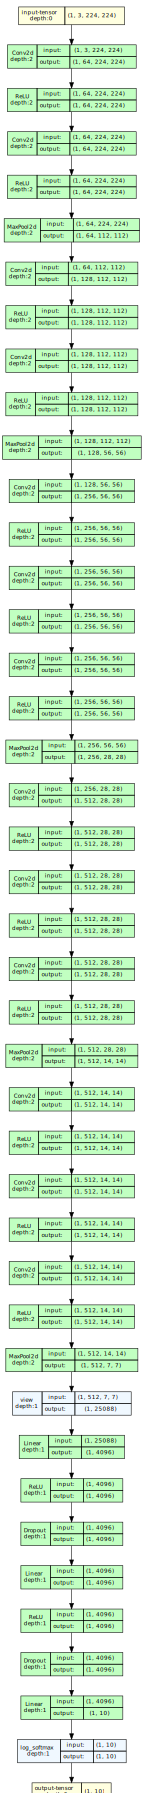

In [11]:
from torchview import draw_graph
model = VGG_Network(input_size, num_classes, config='vgg11').to(device)
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(1, 3, 224, 224), device=device)
model_graph.visual_graph

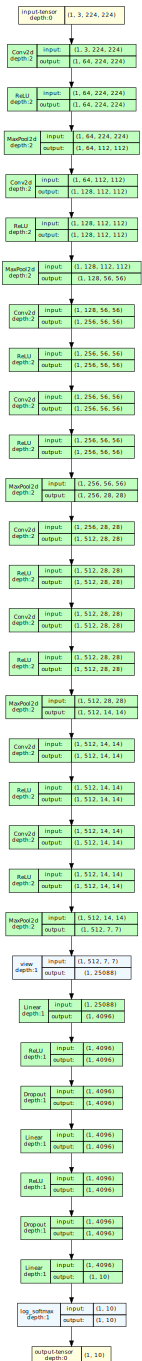

In [12]:
from torchview import draw_graph
model = VGG_Network(input_size, num_classes, config='vgg16').to(device)
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(1, 3, 224, 224), device=device)
model_graph.visual_graph